In [1]:
#Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

#Import Statements- "matplotlib" is used for backend plotting in Jupyter notebooks
from plantcv import plantcv as pcv
import matplotlib
import matplotlib.pyplot as plt
import argparse
import numpy as np 
import cv2

In [2]:
#Set figure size for the notebook
matplotlib.rcParams["figure.figsize"]= (8,8)

In [3]:
#Set up code that will help this script to eventually run in Parallel

#The options class mimics the workflow command-line argument parser 
#that is used for workflow parallelization. Using it while developing 
#a workflow in Jupyter makes it easier to convert the workflow to a script later.
class options:
    def __init__(self):        
        self.image = "./20-1_rep1_h2.jpg" #put the images in the same location as the jupyter notebook
        self.debug = "plot" #Set self.debug to "plot" so that image outputs for each step is shown
        self.writeimg = False
        self.result = "berry_results"
        self.outdir = "."
        
#get options
args = options()

#set debug to the global parameter
pcv.params.debug = args.debug

#increase text size in plots
pcv.params.text_size = 50
pcv.params.text_thickness = 100

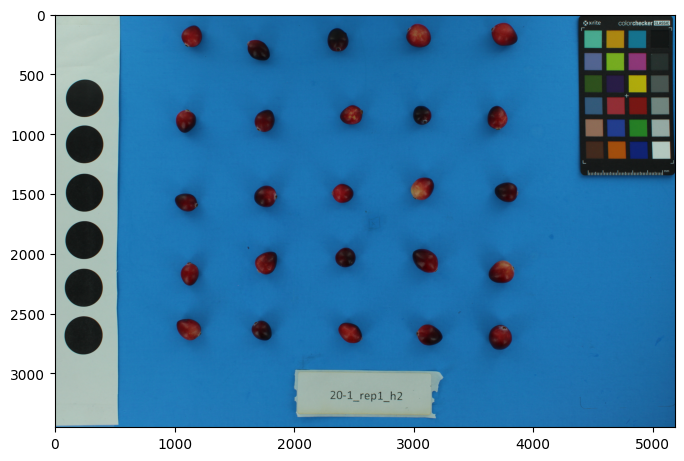

In [4]:
#Read the image
img1, path, filename = pcv.readimage(filename=args.image)

In [5]:
#Now we will use a type of machine
#learning algorithm called "template matching". This technique is best used in situations where you have some object
#of consistent size, shape, and color in all your images (our template) that we can have an algorithm scan images for.
#This will not work well for segmenting objects that will vary in color, shape and size from image to image, but 
#is a great solution for finding color cards, tags, or scaling markers from image to image.

#template matching algorithms require greyscale images (2d matrix rather than a 3d matrix of an RGB image)
#Import the image to be analyzed as a greyscale (add the ", 0" to make it greyscale)
img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
H,W = img.shape

#Import the template (object of interest we want to find in our image)
#template matching algorithms require that the template be imported as a greyscale image (add the ", 0" to make it greyscale)
template = cv2.imread('WB_Standard.jpg', 0)
h,w = template.shape

#match our template to our image using one of 6 different methods for template matching
#template matching essentially just takes the template and moves it along the image (convolution) until it finds a region 
#of pixels in the greyscale image that appear to be a good match
#Test a bunch of different template matching algorithms that are available in openCV (these are the 6 main ones)
#methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR, cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]
#After testing on multiple images, the cv2.TM_CCOEFF seems like the most robust algorithm.
result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF)

#W = width of image, w = width of template
#H = height of image, h = height of template
#+1 = 1 position of movement
#The following line defined how the template gets dragged across the larger image to find a good region of pixels 
#that it matches to. Essentially defines the number of positions we can slide the template across the image in the 
#'x' direction and the 'y' direction. This also defines the size of our output array. The output array tells us what areas 
#of our image most closely match our template.
(W - w + 1, H - h + 1)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

#For any algorithm other than cv2.TM_SQDIFF or cv2.TM_SQDIFF_NORMED, we want to use the "max_loc" value
#to define the position of our object. Keep in mind these x, y coordinates are stored as a tuple and will
#need to be converted to an integer to use in further functions later in the script.
location = max_loc

#convert tuple to integer and print the x, y coordinates of the object of interest
x = int(location[0])
print(x)
y = int(location[1])
print(y)

4974
1042


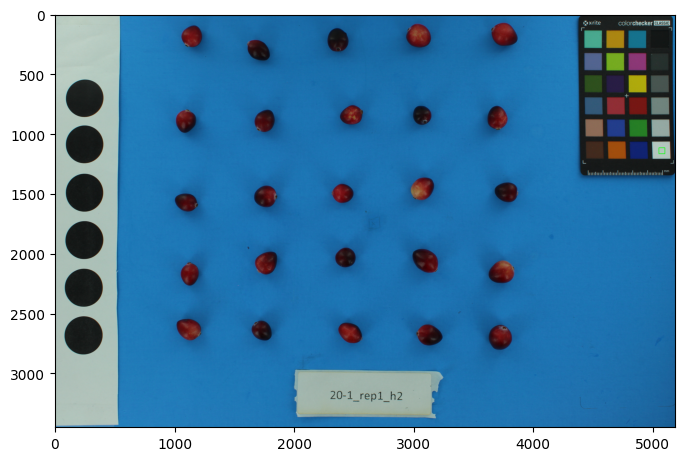

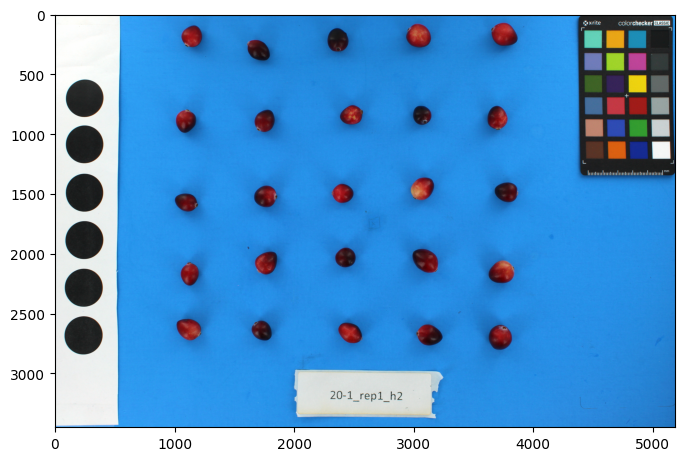

In [6]:
#Normalize the white color on a color card so you can later compare color between images. 
#we will use the coordinates for the white square of the color card identified using our template
#matching algorithm above.

# Inputs:
#   img = image object, RGB color space
#   roi = coordinates where white reference is located, if none, it will use the whole image,
#         otherwise (x position, y position, box width, box height)

# white balance image based on white square from color card 
img2 = pcv.white_balance(img1, roi=(int(x+75),int(y+75),50,50))
#For QC, print out a copy of images showing what ROI was used for white balance correction
WB_ROI=cv2.rectangle(img2,(int(x+75),int(y+75)),(int(x+50),int(y+50)),(0,0,255), 10)
#pcv.print_image(WB_ROI, "./" + filename + "_Standardized_White_Balance.jpg")

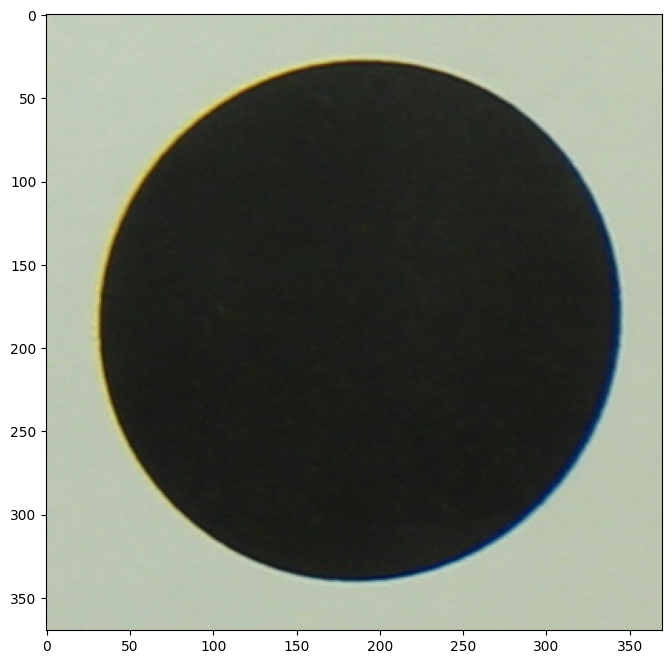

In [7]:
crop_img = img1[520:890, 60:430]
plt.imshow(crop_img)
plt.show()

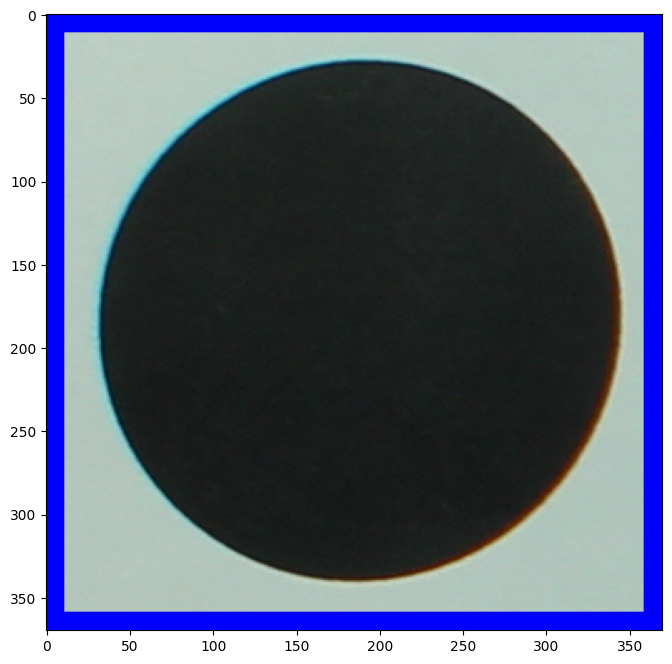

ValueError: not enough values to unpack (expected 2, got 1)

In [8]:
# Step 2: Get the size of the marker. 
# Set global debug behavior to None (default), "print" (to file), 
# or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "plot"
pcv.params.line_thickness = 20

# First make a region of interest around the scale (coin or spot of known size). 
# Then use `report_size_marker_area`
# pretend a berry is the scale marker
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=crop_img, x=0, y=0, h=370, w=370)

# Detect and Measure Size Marker
image = pcv.report_size_marker_area(img=crop_img, roi_contour=roi_contour, roi_hierarchy=roi_hierarchy, 
                    marker='detect', objcolor='dark', thresh_channel='v', thresh=100, label="default")

# Access data stored out from report_size_marker_area
marker_area = pcv.outputs.observations['default']['marker_area']['value']
print(marker_area)

In [ ]:
crop_img2 = img1[3000:3300, 2100:3000]
plt.imshow(crop_img2)
plt.show()

In [ ]:
v = pcv.rgb2gray_hsv(rgb_img=crop_img2, channel="v")

In [ ]:
masked2, masked = pcv.threshold.custom_range(img=v, lower_thresh=[150], upper_thresh=[255])

In [ ]:
inverted_img = pcv.invert(masked2)

In [ ]:
inverted_img = pcv.fill(bin_img=inverted_img, size=200)

In [ ]:
#To identify the label in the image and read the text on the label, we will use a package called "tesseract"
#Tesseract is what is called an OCR = optical character recognition system
#First we need to install pytesseract on our local machine to run this (cant just be installed in anaconda environemnt)
#If installing on a Windows machine, download tesseract here: https://digi.bib.uni-mannheim.de/tesseract/ 
#If installing on a Mac, tesseract will need to be installed with HomeBrew. If you dont have HomeBrew already installed,
#go to Homebrew's site (http://brew.sh/), open your terminal, and run the script that is on the front page.
#After HomeBrew is installed, run the following command to install tesseract: "brew install tesseract"

from pytesseract import pytesseract

#Be aware that pytesseract is just a nice Python wrapper for the command line program Tesseract. 
#You're supposed to point tesseract_cmd at the actual Tesseract binary, not the pytesseract CLI util.
#To find the location of the actual tesseract binary, in your terminal run "brew list tesseract"
pytesseract.tesseract_cmd = "/usr/local/Cellar/tesseract/5.2.0/bin/tesseract"

# Adding custom options
#PSM = page segmentation mode, adjusting this to a different segmentation method (there are 14 different methods)
#can have a big impact on how well it recognizes your text. The default psm in tesseract is optimized to 
#interpret pages of text. Adjusting this can improve the ability to read smaller pieces of information in an
#image like labels. You can then apply a given PSM by supplying the corresponding integer value for the --psm argument.
#For reference, page segmentation modes are:
#  0    Orientation and script detection (OSD) only.
#  1    Automatic page segmentation with OSD.
#  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
#  3    Fully automatic page segmentation, but no OSD. (Default)
#  4    Assume a single column of text of variable sizes.
#  5    Assume a single uniform block of vertically aligned text.
#  6    Assume a single uniform block of text.
#  7    Treat the image as a single text line.
#  8    Treat the image as a single word.
#  9    Treat the image as a single word in a circle.
# 10    Treat the image as a single character.
# 11    Sparse text. Find as much text as possible in no particular order.
# 12    Sparse text with OSD.
# 13    Raw line. Treat the image as a single text line,
#       bypassing hacks that are Tesseract-specific.
custom_config = r'--oem 3 --psm 7'

SampleID = pytesseract.image_to_string(inverted_img)
print("LABEL INFORMATION = ", SampleID)

#the following code will draw boxes around all letters that were identified
height, width, c = crop_img2.shape
SampleID_Boxes = pytesseract.image_to_boxes(inverted_img)
for box in SampleID_Boxes.splitlines():
    box = box.split()
    x,y,w,h = int(box[1]), int(box[2]), int(box[3]), int(box[4])
    cv2.rectangle(crop_img2, (x,height-y), (w,height-h), (0,0,225), 3)
    #print what text is identified on the image next to the boxes
    annotatedimg = cv2.putText(crop_img2, box[0], (x,height-h+32), cv2.FONT_HERSHEY_COMPLEX, 1, (255,0,0), 2)
    annotatedimg2=cv2.cvtColor(annotatedimg, cv2.COLOR_BGR2RGB)
    
plt.imshow(annotatedimg2)
plt.show()

In [ ]:
#Step 3: segment object from the background
#First begin by looking at each of the channels from the HSV and LAB color spaces
#This will hlep us decide what colorspace/channels will help us best threshold the object of interest

cs_plot = pcv.visualize.colorspaces(rgb_img=img1, original_img=True) #this is a tool to show the image in different colorspaces to help us find what channel will work best for thresholding

In [ ]:
#lets look closer at thresholding based on "S" from HSV colorspace
s = pcv.rgb2gray_hsv(rgb_img=img1, channel="s")

In [ ]:
#now lets try to threshold object out of background by the "S" channel
img_binary = pcv.threshold.binary(gray_img=s, threshold=200, max_value=255, object_type="dark")

In [ ]:
# Fill in small objects (speckles)

# Inputs:
#    bin_img  = binary image. img will be returned after filling
#    size     = minimum object area size in pixels (integer)
fill_image = pcv.fill(bin_img=img_binary, size=900)


In [ ]:
# Apply fill holes to a binary image 
fill_objects = pcv.fill_holes(bin_img=fill_image)

In [ ]:
# Define region of interest (ROI)

# Inputs:
#    img   = An RGB or grayscale image to plot the ROI on.
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    h     = The width of the rectangle.
#    w     = The height of the rectangle.
#   roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1) 
#                                                  |______________|
#                                            adjust these four values
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=fill_objects, x=670, y=20, h=2900, w=3600)

In [ ]:
# Find objects (contours: black-white boundaries)

# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection
id_objects, obj_hierarchy = pcv.find_objects(img=img1, mask=fill_objects)

In [ ]:
# Keep objects that overlap with the ROI

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

roi_objects, roi_obj_hierarchy, kept_berries, obj_area = pcv.roi_objects(img=img1, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='partial')

In [ ]:
# Find number of cranberries

# Inputs:
#    contours = list of contours
number_berries = len(roi_objects)

pcv.outputs.add_observation(sample='default', variable='number_berries', trait='number of berries detected in the image',
                            method='count', scale='count', datatype=float,
                            value=number_berries, label='count')

pcv.outputs.observations['default']['number_berries']['value']

In [ ]:
#now we need to organize the berries in the image and assign them ID numbers
#so we can reference what data goes to what berry in an image. Unforuntately, 
#there is no simply function in plantcv/opencv for this so we nee to have some code
#that will first organzie all of the objects in the image into rows, then subsequently
#sort the objects within each row from left to right based on position.
#We can accomplish this by first applying a long horizontal kernel to close objects adjacent
#to one another into a single row. Then we get the contours of the rows and their bounding boxes
#Then we save the row boxes and sort on Y. We then loop over each sorted row box and 
#extract the row from the thresholded image. We get the contours of each objects in the 
#row and save the the bounding boxes of the object and sort the contours for a given row on X.
pcv.params.debug = None

# read input image
img = img2
img3 = img.copy()

# apply long thing kernal and morphology close to form rows from objects
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1000,1))
morph = cv2.morphologyEx(kept_berries, cv2.MORPH_CLOSE, kernel)

# find contours and bounding boxes of rows
rows_img = img.copy()
boxes_img = img.copy()
rowboxes = []
rowcontours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rowcontours = rowcontours[0] if len(rowcontours) == 2 else rowcontours[1]
index = 1
for rowcntr in rowcontours:
    xr,yr,wr,hr = cv2.boundingRect(rowcntr)
    cv2.rectangle(rows_img, (xr, yr), (xr+wr, yr+hr), (0, 0, 255), 3)
    rowboxes.append((xr,yr,wr,hr))

# sort rowboxes on y coordinate
def takeSecond(elem):
    return elem[1]
rowboxes.sort(key=takeSecond)
    
# loop over each row    
for rowbox in rowboxes:
    # crop the image for a given row
    xr = rowbox[0]
    yr = rowbox[1]
    wr = rowbox[2]
    hr = rowbox[3]  
    row = kept_berries[yr:yr+hr, xr:xr+wr]
    bboxes = []
    # find contours of each object in the row
    contours = cv2.findContours(row, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 2000:
            x,y,w,h = cv2.boundingRect(cntr)
            bboxes.append((x+xr,y+yr,w,h))
    # sort bboxes on x coordinate
    def takeFirst(elem):
        return elem[0]
    bboxes.sort(key=takeFirst)
    # draw sorted boxes
    for box in bboxes:
        xb = box[0]
        yb = box[1]
        wb = box[2]
        hb = box[3]
        cv2.rectangle(boxes_img, (xb, yb), (xb+wb, yb+hb), (0, 0, 255), 10)
        cv2.putText(boxes_img, str(index), (xb,yb), cv2.FONT_HERSHEY_COMPLEX_SMALL, fontScale=5, color=(0,0,255), thickness=10)
        roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img3, x=xb, y=yb, h=hb, w=wb)
        roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img2, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='partial')
        fruit, fruit_mask = pcv.object_composition(img=img3, contours=roi_objects, hierarchy=roi_obj_hierarchy)
        color_img = pcv.analyze_color(rgb_img=img3, mask=fruit_mask, hist_plot_type=None, label=f"Berry_{str(index)}")
        img3 = pcv.analyze_object(img=img3, obj=fruit, mask=fruit_mask, label=f"Berry_{str(index)}")
        cv2.putText(img3, str(index), (xb,yb), cv2.FONT_HERSHEY_COMPLEX_SMALL, fontScale=5, color=(0,0,255), thickness=10)
        index = index + 1

In [ ]:
# show images of how objects were sorted from top left to bottom right
pcv.params.debug = "plot"
plt.imshow(morph)
plt.show()
plt.imshow(cv2.cvtColor(rows_img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(boxes_img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# During analysis, measurements are stored in the background in the outputs recorder.

#This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 
#'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 
#'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 
#'ellipse_eccentricity' using anayze_object and color analysis using analyze_color.

#Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, 
#save results as "json"

pcv.outputs.save_results(filename=args.result, outformat="csv")

In [ ]:
#Now we will classify the pixels that make up the berries into "color bins" representing human-visible colors
# Appy Mask (for VIS images, mask_color='white')

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
masked = pcv.apply_mask(img=img1, mask=kept_berries, mask_color='white')

In [ ]:
#The Naive Bayes Multiclass Approach: quantifying color bins
#This is a machine learning approach that can be trained to 
#output binary images given an input color image. 
#The naive Bayes multiclass approach can be trained to classify two or more classes. 
#The naive Bayes multiclass method is trained using colors sparsely sampled from 
#images rather than the need to label all pixels in a given image.

#To train the classifier, we need to build a table of red, green, and blue color values 
#for pixels sampled evenly from each class. The idea here is to collect a relevant sample 
#of pixel color data for each class. The size of the sample needed to build robust 
#probability density functions for each class will depend on a number of factors, 
#including the variability in class colors and imaging quality/reproducibility. 
#To collect pixel color data we currently use the Pixel Inspection Tool in ImageJ. 
#Each column in the tab-delimited table is a feature class and each cell is a 
#comma-separated red, green, and blue triplet for a pixel.

#Once a satisfactory sample of pixels is collected, save the table as a tab-delimited text file. 
#Use plantcv-train.py in a python terminal to use the pixel samples to output probability density functions (PDFs) for each class.
#plantcv-train.py is a command-line tool for training machine learning classifiers or other models in PlantCV.
#usage: plantcv-train.py [-h] {naive_bayes,naive_bayes_multiclass}

#Subcommands:
#    naive_bayes
#        usage: plantcv-train.py naive_bayes [-h] -i IMGDIR -b MASKDIR -o OUTFILE [-p]

#        optional arguments:
#            -h, --help                       Show this help message and exit
#            -i IMGDIR, --imgdir IMGDIR       Input directory containing images.
#            -b MASKDIR, --maskdir MASKDIR    Input directory containing black/white masks.
#            -o OUTFILE, --outfile OUTFILE    Trained classifier output filename.
#            -p, --plots                      Make output plots.

#    naive_bayes_multiclass
#        usage: plantcv-train.py naive_bayes_multiclass [-h] -f FILE -o OUTFILE [-p]

#        optional arguments:
#            -h, --help                       Show this help message and exit
#            -f FILE, --file FILE             Input file containing a table of pixel RGB values sampled for each input 
#                                             class.
#            -o OUTFILE, --outfile OUTFILE    Trained classifier output filename.
#            -p, --plots                      Make output plots.

#python3 plantcv-train.py naive_bayes_multiclass  -f ../Naive.Bayes.Train.txt -o ../naive_bayes_pdfs.txt

#Once the PDF is created, use the output file to run the multiclass 
# naive bayes classification on the image. The function below will 
# print out 6 masks for each color class (class1, class2, class3, class6, class8, class10)

# Inputs: 
#   rgb_img - RGB image data 
#   pdf_file - Output file containing PDFs from `plantcv-train.py`
mask = pcv.naive_bayes_classifier(rgb_img=masked, 
                                  pdf_file="./naive_bayes_pdfs.txt")

In [ ]:
# We can apply each mask to the original image to more accurately 
# see what got masked

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
class1_img = pcv.apply_mask(mask=(mask['class1']), img=img1, mask_color='black')
class2_img = pcv.apply_mask(mask=(mask['class2']), img=img1, mask_color='black')
class3_img = pcv.apply_mask(mask=(mask['class3']), img=img1, mask_color='black')
class4_img = pcv.apply_mask(mask=(mask['class4']), img=img1, mask_color='black')
class5_img = pcv.apply_mask(mask=(mask['class5']), img=img1, mask_color='black')
background_img = pcv.apply_mask(mask=(mask['background']), img=img1, mask_color='black')

In [ ]:
# Write image and mask with the same name to the path 
# specified (creates two folders within the path if they do not exist).

# Inputs: 
#   img - RGB or grayscale image data, original image 
#   mask - Binary mask image created 
#   filename - Image filename to get saved as
#   outdir - Output directory (default: None)
#   mask_only - Defaults to False, if True then only outputs mask 
class1_maskpath, class1_analysis_images = pcv.output_mask(img=img1, mask=mask['class1'], 
                                                        filename='class1.png', mask_only=True)
class2_maskpath, class2_analysis_images = pcv.output_mask(img=img1, mask=mask['class2'], 
                                                      filename='class2.png', mask_only=True)
class3_maskpath, class3_analysis_images = pcv.output_mask(img=img1, mask=mask['class3'], 
                                                        filename='class3.png', mask_only=True)
class4_maskpath, class4_analysis_images = pcv.output_mask(img=img1, mask=mask['class4'], 
                                                        filename='class4.png', mask_only=True)
class5_maskpath, class5_analysis_images = pcv.output_mask(img=img1, mask=mask['class5'], 
                                                        filename='class5.png', mask_only=True)

In [ ]:
# To see all of these masks together we can plot them with class1 set to green,
# class2 set to red, class3 set to gold, class6 set to gray, class8 is set to blue, class10 is set to white.

# Inputs:
#   masks - List of masks (the different classes returned by naive_bayes_classifier)
#   colors - List of colors to assign to each class. Users can either provide a 
#   list of color names (str) or can provide tuples of custom BGR values
classified_img = pcv.visualize.colorize_masks(masks=[mask['class1'], mask['class2'], 
                                                     mask['class3'], mask['class4'],
                                                     mask['class5']], 
                                              colors=['dark green', 'red', 'gold', 'gray', 'blue'])
pcv.print_image(classified_img, "./NiaveBayes_classification.jpg")

In [ ]:
# Calculate percent of the fruit that is red
unripe_skin = np.count_nonzero(mask['class1']) + np.count_nonzero(mask['class2']) + np.count_nonzero(mask['class3'])
ripe_skin = np.count_nonzero(mask['class4']) + np.count_nonzero(mask['class5'])
percent_unripe_skin = unripe_skin / (unripe_skin + ripe_skin)

In [ ]:

import numpy as np

# Calculate percent of the plant found to be diseased 
total_endocarp = np.count_nonzero(mask['class1']) + np.count_nonzero(mask['class2']) + np.count_nonzero(mask['class3']) + np.count_nonzero(mask['class4']) + np.count_nonzero(mask['class5'])
percent_class1 = (np.count_nonzero(mask['class1'])/total_endocarp)*100
percent_class2 = (np.count_nonzero(mask['class2'])/total_endocarp)*100
percent_class3 = (np.count_nonzero(mask['class3'])/total_endocarp)*100
percent_class4 = (np.count_nonzero(mask['class4'])/total_endocarp)*100
percent_class5 = (np.count_nonzero(mask['class5'])/total_endocarp)*100

In [ ]:
# Create a new measurement (gets saved to the outputs class) 

# Inputs:
#    sample - A sample name or label
#    variable - The name of the variable for the observation to get stored. Must be unique to other variable names
#               since data is a dictionary format where variable is the key.
#    trait - Description of the observation getting stored
#    method - Description of the method for calculating the observation
#    scale - Observation scale
#    datatype - The datatype of the observation, most commonly either bool, str, int, float, list 
#    value - Value of the observation getting stored
#    label - Label for the observation getting stored. Required for list datatype observations. 

pcv.outputs.add_observation(sample='default', variable='class1', trait='pixels assigned to the class1 color bin',
                            method='number of pixels', scale='count', datatype=float,
                            value=np.count_nonzero(mask['class1']), label='pixels')

pcv.outputs.add_observation(sample='default', variable='percent_class1', trait='percent area assigned to the class1 color bin',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_class1, label='percent')

pcv.outputs.add_observation(sample='default', variable='class2', trait='pixels assigned to the class2 color bin',
                            method='number of pixels', scale='count', datatype=float,
                            value=np.count_nonzero(mask['class2']), label='pixels')

pcv.outputs.add_observation(sample='default', variable='percent_class2', trait='percent area assigned to the class2 color bin',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_class2, label='percent')

pcv.outputs.add_observation(sample='default', variable='class3', trait='pixels assigned to the class3 color bin',
                            method='number of pixels', scale='count', datatype=float,
                            value=np.count_nonzero(mask['class3']), label='pixels')

pcv.outputs.add_observation(sample='default', variable='percent_class3', trait='percent area assigned to the class3 color bin',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_class3, label='percent')

pcv.outputs.add_observation(sample='default', variable='class4', trait='pixels assigned to the class4 color bin',
                            method='number of pixels', scale='count', datatype=float,
                            value=np.count_nonzero(mask['class4']), label='pixels')

pcv.outputs.add_observation(sample='default', variable='percent_class4', trait='percent area assigned to the class4 color bin',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_class4, label='percent')

pcv.outputs.add_observation(sample='default', variable='class5', trait='pixels assigned to the class5 color bin',
                            method='number of pixels', scale='count', datatype=float,
                            value=np.count_nonzero(mask['class5']), label='pixels')

pcv.outputs.add_observation(sample='default', variable='percent_class5', trait='percent area assigned to the class5 color bin',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_class5, label='percent')

pcv.outputs.add_observation(sample='default', variable='percent_unripe_skin', trait='percent of skin detected to be unripe',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_unripe_skin, label='percent')

In [ ]:
# Data stored to the outputs class can be accessed using the variable name
pcv.outputs.observations['default']['percent_unripe_skin']['value']